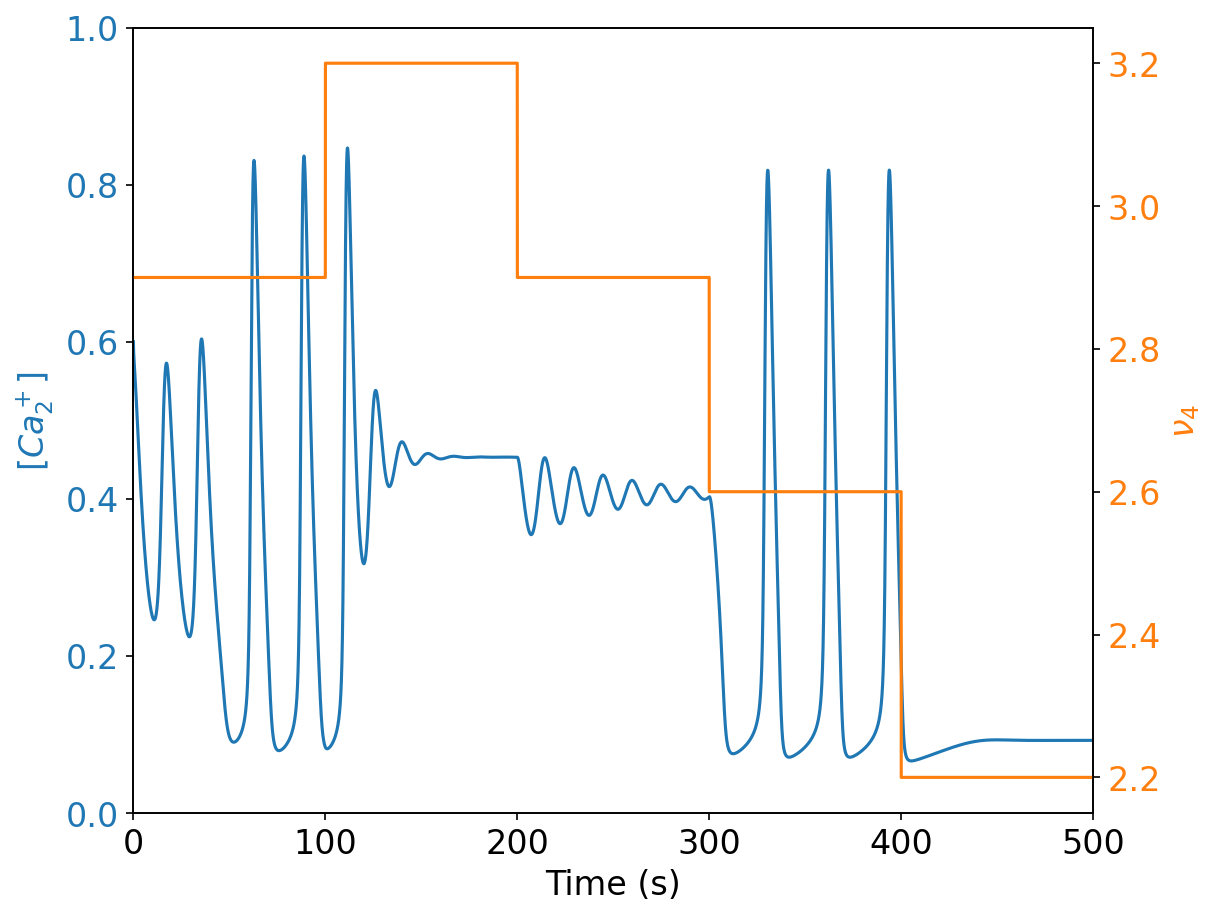

In [66]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

c1 = 0.185
c0 = 2
nu1 = 6
nu2 = 0.11
nu3 = 0.9
k3 = 0.1
k4 = 1.1

a1 = 400
a2 = 0.2
a3 = 400
a4 = 0.2
a5 = 20

d1 = 0.13
d2 = 1.049
d3 = 943.4e-3
d4 = 144.5e-3
d5 = 82.34e-3

Ir = 1
alpha = 0.97
# nu4 = 2.8

J1 = lambda C, CER, x110: c1 * (nu1 * x110 ** 3 + nu2) * (CER - C)
J2 = lambda C: nu3 * C**2 / (C**2 + k3**2)
CER = lambda C: (c0 - C) / c1
dCdt = lambda C, x110: J1(C, CER(C), x110) - J2(C)
dPdt = lambda C, P, nu4: nu4 * (C + (1 - alpha) * k4) / (C + k4) - Ir * P

def nu4_time(t):
    if t < 100:
        return 2.9
    if t < 200:
        return 3.2
    elif t < 300:
        return 2.9
    elif t < 400:
        return 2.6
    else:
        return 2.2

def deyoungkeizerode(t, x):
    nu4 = nu4_time(t)
    C, P, x000, x001, x010, x011, x100, x101, x110 = x
    x111 = 1 - x000 - x001 - x010 - x011 - x100 - x101 - x110

    # print(x000 + x001 + x010 + x011 + x100 + x101 + x110 + x111)

    # Bottom face
    V1 = a4 * (C * x000 - d4 * x001) # x000 to x001
    V2 = a4 * (C * x010 - d4 * x011) # x010 to x011
    V3 = a5 * (C * x000 - d5 * x010) # x000 to x010
    V4 = a5 * (C * x001 - d5 * x011) # x001 to x011

    # Sides
    V5 = a1 * (P * x000 - d1 * x100) # x000 to x100
    V6 = a1 * (P * x010 - d1 * x110) # x010 to x110
    V7 = a3 * (P * x001 - d3 * x101) # x001 to x101
    V8 = a3 * (P * x011 - d3 * x111) # x011 to x111

    # Top face
    V9 = a2 * (C * x100 - d2 * x101) # x100 to x101
    V10 = a2 * (C * x110 - d2 * x111) # x110 to x111
    V11 = a5 * (C * x100 - d5 * x110) # x100 to x110
    V12 = a5 * (C * x101 - d5 * x111) # x101 to x111

    dx000dt = -V1 - V3 - V5
    dx001dt = V1 - V4 - V7
    dx010dt = V3 - V2 - V6
    dx011dt = V2 + V4 - V8

    dx100dt = V5 - V9 - V11
    dx101dt = V7 + V9 - V12
    dx110dt = V6 - V10 + V11

    # print(dx000dt + dx001dt + dx010dt + dx011dt + dx100dt + dx101dt + dx110dt + dx111dt)
    # print(sum([x000, x001, x010, x011, x100, x101, x110, x111]))

    return [dCdt(C, x110), dPdt(C, P, nu4), dx000dt, dx001dt, dx010dt, dx011dt, dx100dt, dx101dt, dx110dt]

plt, ax1 = plt.subplots(figsize=(8, 6), layout='constrained')
ax2 = ax1.twinx()
# nu4 = 2.9
t_span = [0, 500]
y0 = [0.6, 0.8106048027812828, 0.014034676849733505, 0.038289093137798734, 0.06721492403612747, 0.18337426035699705, 0.0875121331640048, 0.03289942965888928, 0.41911341784615047]
sol = solve_ivp(deyoungkeizerode, t_span, y0, args=(), max_step=0.1, rtol=1e-6, atol=1e-8)
ax1.plot(sol.t, sol.y[0], 'C0')
ax2.plot(sol.t, [nu4_time(t) for t in sol.t], 'C1')
# plt.plot(sol.t, sol.y[1])
# for i in range(8):
#     plt.plot(sol.t, sol.y[i])
ax1.set_xlim(0, 500)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('$[Ca_2^+]$', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax2.set_ylabel('$\\nu_4$', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
# print(', '.join(list(map(str, sol.y[:, -1]))))
plt.savefig('extended_time_trace.pdf')

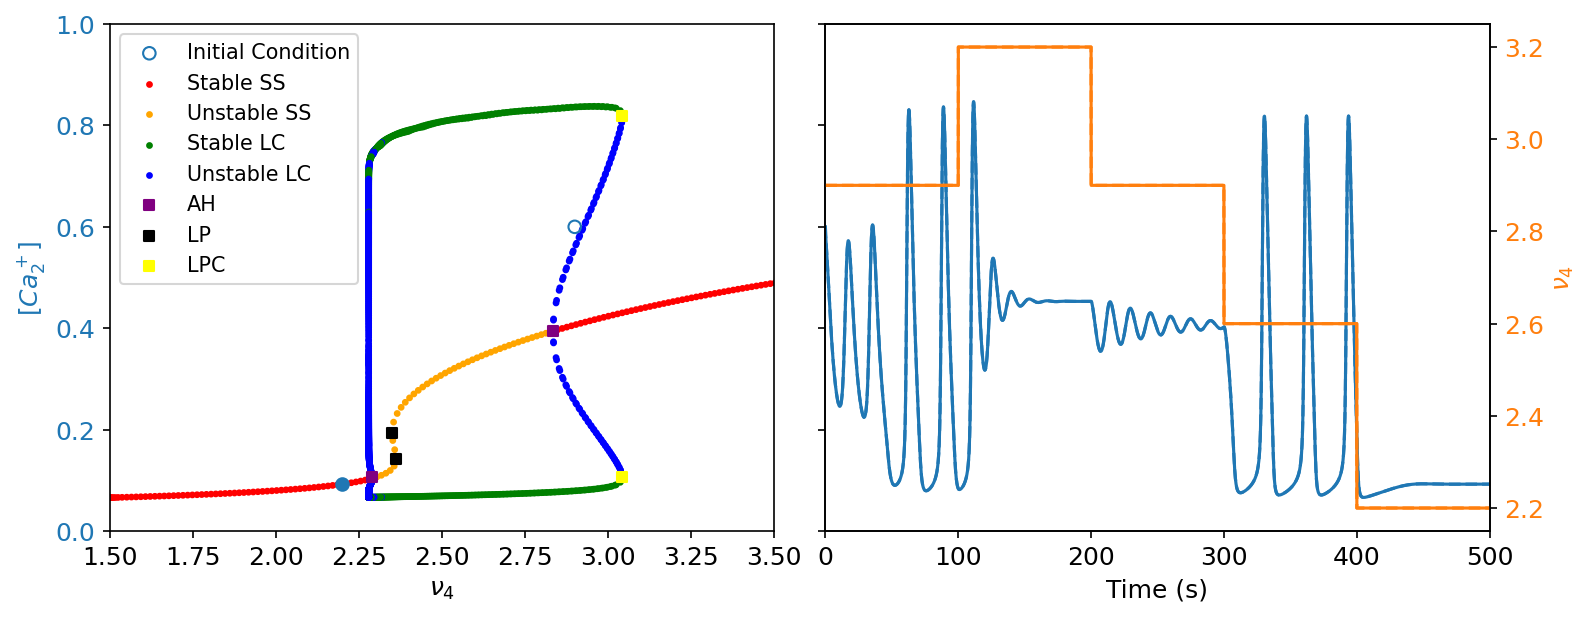

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 12

fig, axs = plt.subplots(1, 2, sharey=True, layout='constrained', figsize=(10.5, 4))
ax1 = axs[0]
ax2 = axs[1]
ax1.set_ylabel('$[Ca_2^+]$', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_xlabel('$\\nu_4$')

data = pd.read_csv('..\\bifurcation_branch_new.csv')
periodic = pd.read_csv('..\\hopf_po_gamma_branch.csv')
ax1.scatter(data['nu4'], data['V'], color=list(map(lambda x: 'r' if x else 'orange', data['stable'])), s=5)
ax1.scatter(periodic['param'], periodic['max'], color=list(map(lambda x: 'g' if x else 'b', periodic['stable'])), s=5)
ax1.scatter(periodic['param'], periodic['min'], color=list(map(lambda x: 'g' if x else 'b', periodic['stable'])), s=5)
ax1.scatter(nu4_time(0), y0[0], edgecolors='C0', facecolor='None', label='Initial Condition')

ax1.scatter(2.2904403, 0.10678342577131315, marker='s', color='purple', s=20)
ax1.scatter(2.83454206, 0.39434307976476896, marker='s', color='purple', s=20)
ax1.scatter(2.36193837, 0.14249978379472195, marker='s', color='black', s=20)
ax1.scatter(2.35015804, 0.19406114511676725, marker='s', color='black', s=20)

ax1.scatter(3.043511591928886, 0.8180252554173874, marker='s', color='yellow', s=20)
ax1.scatter(3.043511591928886, 0.10590056660936525, marker='s', color='yellow', s=20)

ax1.scatter([], [], color='red', s=5, label='Stable SS')
ax1.scatter([], [], color='orange', s=5, label='Unstable SS')
ax1.scatter([], [], color='green', s=5, label='Stable LC')
ax1.scatter([], [], color='blue', s=5, label='Unstable LC')
ax1.scatter([], [], color='purple', s=20, marker='s', label='AH')
ax1.scatter([], [], color='black', s=20, marker='s', label='LP')
ax1.scatter([], [], color='yellow', s=20, marker='s', label='LPC')
ax1.legend(fontsize='small', loc='upper left')

ax1.set_xlim(1.5, 3.5)

ax2.plot(sol.t, sol.y[0], 'C0--')
ax2.set_xlim(0, 500)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Time (s)')
ax3 = ax2.twinx()
ax3.plot(sol.t, [nu4_time(t) for t in sol.t], 'C1--')
ax3.set_ylabel('$\\nu_4$', color='C1')
ax3.tick_params(axis='y', labelcolor='C1')

# plt.plot(sol.y[1], sol.y[0])
# plt.plot(np.ones_like(sol.y[0]) * nu4, sol.y[0])
line1, = ax1.plot([], [], 'C0o', label='[$Ca_2^+ (t)$]') # Initial empty plot
line2, = ax2.plot([], [], 'C0-')
line3, = ax3.plot([], [], 'C1-')

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3

def animate(i):
    line1.set_data([nu4_time(sol.t[i*150])], [sol.y[0][i*150]])
    line2.set_data(sol.t[:i*150], sol.y[0][:i*150])
    line3.set_data(sol.t[:i*150], [nu4_time(t) for t in sol.t[:i*150]])
    return line1, line2, line3

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sol.t)//150, interval=50, blit=True, repeat=True)
ani.save('step.mp4')

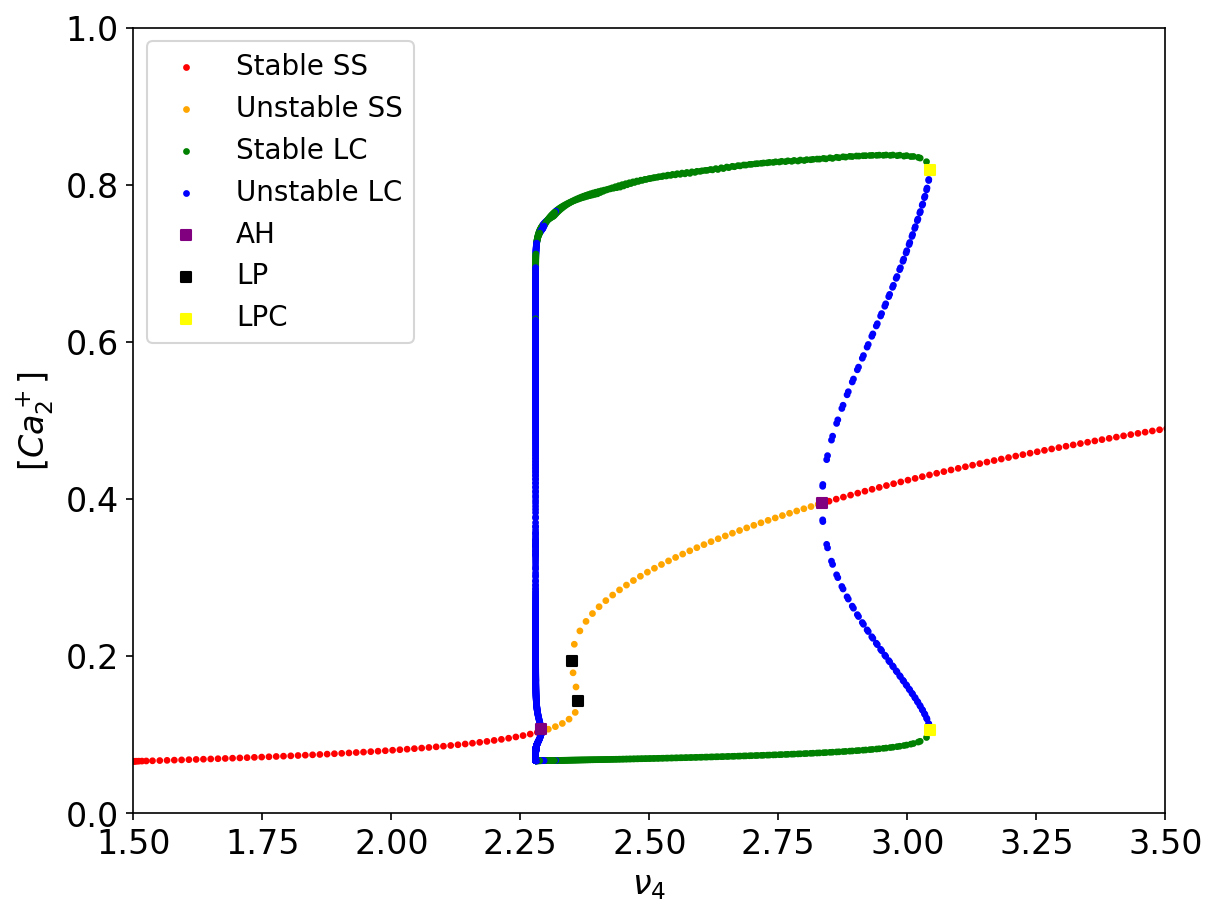

In [57]:
plt.rcParams['font.size'] = 16

plt.figure(figsize=(8, 6), layout='constrained')


data = pd.read_csv('..\\bifurcation_branch_new.csv')
periodic = pd.read_csv('..\\hopf_po_gamma_branch.csv')
plt.scatter(data['nu4'], data['V'], color=list(map(lambda x: 'r' if x else 'orange', data['stable'])), s=5)
plt.scatter(periodic['param'], periodic['max'], color=list(map(lambda x: 'g' if x else 'b', periodic['stable'])), s=5)
plt.scatter(periodic['param'], periodic['min'], color=list(map(lambda x: 'g' if x else 'b', periodic['stable'])), s=5)

plt.scatter(2.2904403, 0.10678342577131315, marker='s', color='purple', s=20)
plt.scatter(2.83454206, 0.39434307976476896, marker='s', color='purple', s=20)
plt.scatter(2.36193837, 0.14249978379472195, marker='s', color='black', s=20)
plt.scatter(2.35015804, 0.19406114511676725, marker='s', color='black', s=20)

plt.scatter(3.043511591928886, 0.8180252554173874, marker='s', color='yellow', s=20)
plt.scatter(3.043511591928886, 0.10590056660936525, marker='s', color='yellow', s=20)

plt.scatter([], [], color='red', s=5, label='Stable SS')
plt.scatter([], [], color='orange', s=5, label='Unstable SS')
plt.scatter([], [], color='green', s=5, label='Stable LC')
plt.scatter([], [], color='blue', s=5, label='Unstable LC')
plt.scatter([], [], color='purple', s=20, marker='s', label='AH')
plt.scatter([], [], color='black', s=20, marker='s', label='LP')
plt.scatter([], [], color='yellow', s=20, marker='s', label='LPC')
plt.legend(fontsize='small', loc='upper left')

plt.xlim(1.5, 3.5)
plt.ylim(0, 1)

plt.ylabel('$[Ca_2^+]$')
plt.xlabel('$\\nu_4$')
plt.savefig('extended_bifurcation.pdf')

Text(0.5, 0, '[IP3]')

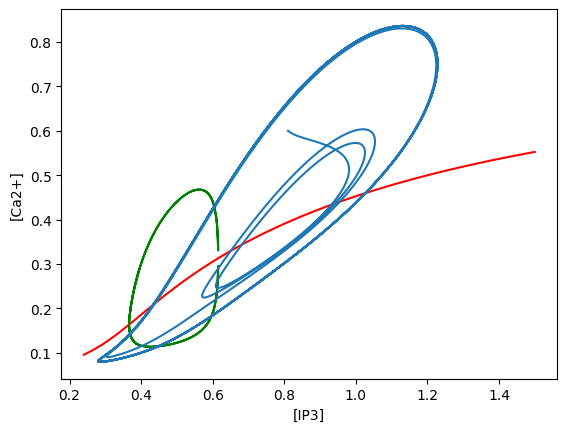

In [13]:
data = pd.read_csv('..\\bifurcation_branch.csv')
periodic = pd.read_csv('..\\periodic_orbits.csv')
plt.plot(data['P'], data['C'], 'r')
plt.plot(periodic['P'], periodic['V_max'], 'g')
plt.plot(periodic['P'], periodic['V_min'], 'g')

# plt.plot(sol.y[1], sol.y[0])
plt.plot(sol.y[1], sol.y[0])
plt.ylabel('[Ca2+]')
plt.xlabel('[IP3]')

Text(0, 0.5, '[Ca2+]')

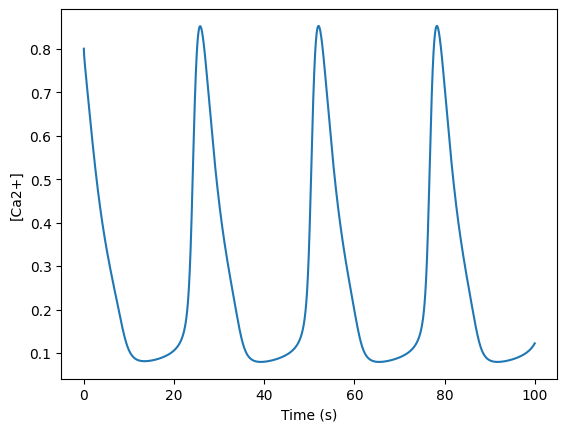

In [20]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

c1 = 0.185
c0 = 2
nu2 = 0.11
nu3 = 0.9
nu4 = 2.8
k3 = 0.1
k4 = 1.1

a1 = 400
a2 = 0.2
a3 = 400
a4 = 0.2
a5 = 20

d1 = 0.13
d2 = 1.049
d3 = 943.4e-3
d4 = 144.5e-3
d5 = 82.34e-3

Ir = 1
alpha = 0.97
# nu4 = 2.8

J1 = lambda C, CER, x110, nu1: c1 * (nu1 * x110 ** 3 + nu2) * (CER - C)
J2 = lambda C: nu3 * C**2 / (C**2 + k3**2)
CER = lambda C: (c0 - C) / c1
dCdt = lambda C, x110, nu1: J1(C, CER(C), x110, nu1) - J2(C)
dPdt = lambda C, P: nu4 * (C + (1 - alpha) * k4) / (C + k4) - Ir * P

def deyoungkeizerode(t, x, nu1):
    C, P, x000, x001, x010, x011, x100, x101, x110 = x
    x111 = 1 - x000 - x001 - x010 - x011 - x100 - x101 - x110

    # print(x000 + x001 + x010 + x011 + x100 + x101 + x110 + x111)

    # Bottom face
    V1 = a4 * (C * x000 - d4 * x001) # x000 to x001
    V2 = a4 * (C * x010 - d4 * x011) # x010 to x011
    V3 = a5 * (C * x000 - d5 * x010) # x000 to x010
    V4 = a5 * (C * x001 - d5 * x011) # x001 to x011

    # Sides
    V5 = a1 * (P * x000 - d1 * x100) # x000 to x100
    V6 = a1 * (P * x010 - d1 * x110) # x010 to x110
    V7 = a3 * (P * x001 - d3 * x101) # x001 to x101
    V8 = a3 * (P * x011 - d3 * x111) # x011 to x111

    # Top face
    V9 = a2 * (C * x100 - d2 * x101) # x100 to x101
    V10 = a2 * (C * x110 - d2 * x111) # x110 to x111
    V11 = a5 * (C * x100 - d5 * x110) # x100 to x110
    V12 = a5 * (C * x101 - d5 * x111) # x101 to x111

    dx000dt = -V1 - V3 - V5
    dx001dt = V1 - V4 - V7
    dx010dt = V3 - V2 - V6
    dx011dt = V2 + V4 - V8

    dx100dt = V5 - V9 - V11
    dx101dt = V7 + V9 - V12
    dx110dt = V6 - V10 + V11

    # print(dx000dt + dx001dt + dx010dt + dx011dt + dx100dt + dx101dt + dx110dt + dx111dt)
    # print(sum([x000, x001, x010, x011, x100, x101, x110, x111]))

    return [dCdt(C, x110, nu1), dPdt(C, P), dx000dt, dx001dt, dx010dt, dx011dt, dx100dt, dx101dt, dx110dt]

nu1 = 6.3
t_span = [0, 100]
y0 = [0.8, 0.8106048027812828, 0.014034676849733505, 0.038289093137798734, 0.06721492403612747, 0.18337426035699705, 0.0875121331640048, 0.03289942965888928, 0.41911341784615047]
sol = solve_ivp(deyoungkeizerode, t_span, y0, args=(nu1,), max_step=0.1, rtol=1e-6, atol=1e-8)
plt.plot(sol.t, sol.y[0])
# plt.plot(sol.t, sol.y[1])
# for i in range(8):
#     plt.plot(sol.t, sol.y[i])
# plt.xlim(40, 140)
# plt.ylim(0, 0.6)
plt.xlabel('Time (s)')
plt.ylabel('[Ca2+]')
# print(', '.join(list(map(str, sol.y[:, -1]))))

In [4]:
from scipy.optimize import fsolve

def find_steady_state(nu4, initial_guess=None):
    if initial_guess is None:
        initial_guess = [0.5, 1, 1, 0, 0, 0, 0, 0, 0]
#
    func = lambda x: deyoungkeizerode(0, x, nu4)
    state = fsolve(func, initial_guess)
    return state

def find_limit_cycle(nu4, initial_state):
    # (min, max)
    t_span = [0, 200]
    sol = solve_ivp(deyoungkeizerode, t_span, initial_state, args=(nu4,), max_step=0.1, rtol=1e-6, atol=1e-6)
    return min(sol.y[0][100:]), max(sol.y[0][100:])

def is_hopf(eigvals, prev_eigvals):
    conjugates = eigvals[np.where(np.imag(eigvals) != 0)]
    if conjugates.size == 0:
        return False

    new_real = np.real(conjugates[0])

    conjugates = prev_eigvals[np.where(np.imag(prev_eigvals) != 0)]
    if conjugates.size == 0:
        return False

    prev_real = np.real(conjugates[0])

    # if new_real * prev_real < 0:
    #     print(new_real, prev_real)

    return new_real * prev_real < 0

def frequency(eigvals):
    conjugates = eigvals[np.where(np.imag(eigvals) != 0)]
    return 1 / 2 / np.pi * 1000 * abs(np.imag(conjugates[0]))

C:\Users\Austin\AppData\Local\Temp\ipykernel_25128\456837764.py:8: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  state = fsolve(func, initial_guess)
C:\Users\Austin\AppData\Local\Temp\ipykernel_25128\456837764.py:8: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  state = fsolve(func, initial_guess)


Text(0.5, 0, '$\\nu_4 (s^{-1})$')

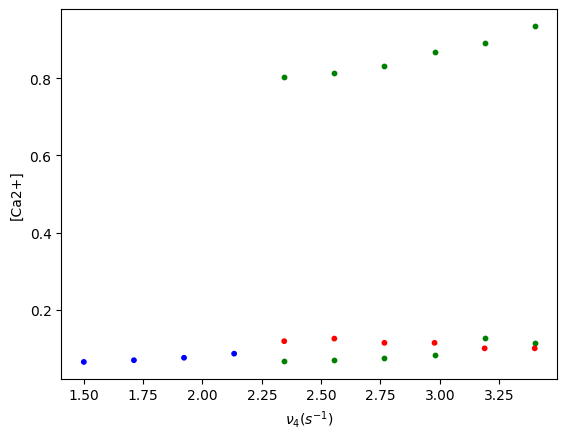

In [8]:
import scipy.differentiate

eps = 1e-10
n_points = 10
nu4s = np.linspace(1.5, 3.4, n_points)
stabilities = np.zeros_like(nu4s)
states = np.zeros((9, n_points))
prev_eigvals = np.zeros(9)
marker_size = 10

for i, nu4 in enumerate(nu4s):
    # print(i)
    if i == 0:
        guess = [0.06587107725689609, 0.12720471099725644, 0.2225037245788215, 0.10163400222531772, 0.17799901877163418, 0.08130538062164984, 0.2177193766479666, 0.013703946438524172, 0.17417162558661056]
    else:
        guess = states[:, i - 1]

    new_state = find_steady_state(nu4, guess)
    eigvals = np.linalg.eigvals(scipy.differentiate.jacobian(lambda x: deyoungkeizerode(0, x, nu4), new_state).df)
    stable = max(eigvals) < eps

    if not stable:
        bounds = find_limit_cycle(nu4, guess)
        plt.scatter(nu4, bounds[0], c='g', s=marker_size)
        plt.scatter(nu4, bounds[1], c='g', s=marker_size)

    if is_hopf(eigvals, prev_eigvals):
        plt.scatter(nu4, new_state[0], c='purple', s=marker_size * 5, zorder=2)
        plt.text(nu4 + 0.05, new_state[0] - 0.02, 'HB')
        print(f'HB ({nu4:.3f}, {new_state[0]:.3f}) | f = {frequency(eigvals):.2f} Hz')

    states[:, i] = new_state
    stabilities[i] = stable
    prev_eigvals = eigvals

colors = ['blue' if stable else 'red' for stable in stabilities]
plt.scatter(nu4s, states[0], c=colors, s=marker_size)
plt.ylabel('[Ca2+]')
plt.xlabel('$\\nu_4 (s^{-1})$')
# plt.legend()